#### **Agent Memory**

##### **Review**

Previously, we built an agent that can:

- `act` - let model call specific tools
- `observe` - pass the tool output back to the model
- `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just responde directly)

##### **Goals**

Now, we're going extend our agent by introducing memory.

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
from langchain_openai import ChatOpenAI

# Tools
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a (int): First number.
        b (int): Second number.
    """
    return a * b


def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a (int): First number.
        b (int): Second number.
    """
    return a + b


def divide(a: int, b: int) -> float:
    """Divides a and b.

    Args:
        a (int): First number.
        b (int): Second number.
    """
    return a / b


tools = [multiply, add, divide]
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm_with_tools = llm.bind_tools(tools)

In [15]:
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpul assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

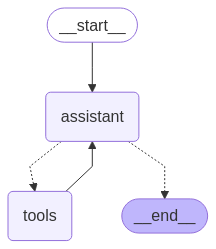

In [16]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import display, Image

# Graph
builder = StateGraph(MessagesState)

# Define nodes" these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is not a tool call -> tools_condition routes to END
    tools_condition,
)

builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))


#### **Memory**

Let's run our agent, as before

In [17]:
messages = [HumanMessage(content="Add 3 and 4.")]
messages = react_graph.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}